# User preference learning

In [1]:
using Revise

using ReactiveMP
using Rocket
using GraphPPL

using Optim
using LinearAlgebra
using Random
using PyPlot
using StatsFuns: normcdf


include("../src/environment/user.jl");

## Flow model

In [2]:
# specify flow model
flow_model = FlowModel(2,
    (
        AdditiveCouplingLayer(PlanarFlow()), # defaults to AdditiveCouplingLayer(PlanarFlow(); permute=true)
        AdditiveCouplingLayer(PlanarFlow()),
        AdditiveCouplingLayer(PlanarFlow(); permute=false)
    )
);

## Inference model optimization

In [3]:
@model function flow_classifier(nr_samples::Int64, model::FlowModel, params)
    
    # initialize variables
    x_lat  = randomvar(nr_samples)
    y_lat1 = randomvar(nr_samples)
    y_lat2 = randomvar(nr_samples)
    y      = datavar(Float64, nr_samples)
    x      = datavar(Vector{Float64}, nr_samples)

    # compile flow model
    meta  = FlowMeta(compile(model, params)) # default: FlowMeta(model, Linearization())

    # specify observations
    for k = 1:nr_samples

        # specify latent state
        x_lat[k] ~ MvNormalMeanPrecision(x[k], 1e3*diagm(ones(2)))


        # specify transformed latent value
        y_lat1[k] ~ Flow(x_lat[k]) where { meta = meta }
        y_lat2[k] ~ dot(y_lat1[k], [1, 1])

        # specify observations
        y[k] ~ Probit(y_lat2[k]) # default: where { pipeline = RequireInbound(in = NormalMeanPrecision(0, 1.0)) }

    end

    # return variables
    return x_lat, x, y_lat1, y_lat2, y

end;

In [4]:
function inference_flow_classifier(data_y::Array{Float64,1}, data_x::Array{Array{Float64,1},1}, model::FlowModel, params)
    
    # fetch number of samples
    nr_samples = length(data_y)

    # define model
    model, (x_lat, x, y_lat1, y_lat2, y) = flow_classifier(nr_samples, model, params)

    # initialize free energy
    fe_buffer = nothing
    
    # subscribe
    fe_sub = subscribe!(score(BetheFreeEnergy(), model), (fe) -> fe_buffer = fe)

    # update y and x according to observations (i.e. perform inference)
    ReactiveMP.update!(y, data_y)
    ReactiveMP.update!(x, data_x)

    # unsubscribe
    unsubscribe!(fe_sub)
    
    # return the marginal values
    return fe_buffer

end;

In [5]:
function calculate_parameters(params, model, data_x, data_y)

    function f(params)
        fe = inference_flow_classifier(data_y, data_x, model, params)
        return fe
    end

    res = optimize(f, params, LBFGS(), Optim.Options(iterations = 500, store_trace = false, show_trace = false), autodiff=:forward)

    return Optim.minimum(res), Optim.minimizer(res)

end

calculate_parameters (generic function with 1 method)

In [6]:
function repeat_calculate_parameters(model, data_x, data_y)
    try
        return calculate_parameters(randn(nr_params(model)), model, data_x, data_y)
    catch
        println("   ERROR: calculate_parameters() failed")
        return repeat_calculate_parameters(model, data_x, data_y)
    end
end

repeat_calculate_parameters (generic function with 1 method)

In [7]:
function calculate_parameters_tries(model, data_x, data_y; nr_tries=1)
    params = []
    fe = []
    for k = 1:nr_tries
        fe_tmp, params_tmp = repeat_calculate_parameters(model, data_x, data_y)
        push!(params, params_tmp)
        push!(fe, fe_tmp)
    end
    return params[argmin(fe)]
end

calculate_parameters_tries (generic function with 1 method)

## Inference input estimation

In [8]:
struct PointMassFormConstraint2{P}
    point :: P   
end

ReactiveMP.default_form_check_strategy(::PointMassFormConstraint2) = FormConstraintCheckLast()

ReactiveMP.is_point_mass_form_constraint(::PointMassFormConstraint2) = true

function ReactiveMP.constrain_form(pmconstraint::PointMassFormConstraint2, message::Message) 
    is_clamped = ReactiveMP.is_clamped(message)
    is_initial = ReactiveMP.is_initial(message)
    return Message(PointMass(pmconstraint.point), is_clamped, is_initial)
end

In [9]:
@model function flow_classifier_input(input, model, params)
    
    # initialize variables
    x_lat  = randomvar()
    y_lat1 = randomvar()
    y_lat2 = randomvar()
    xprior = randomvar() where { form_constraint = PointMassFormConstraint2(input)}
    y = datavar(Float64)

    # specify model
    meta  = FlowMeta(compile(model, params))

    # specify prior on weights
    xprior ~ MvNormalMeanPrecision([0.5,0.5], 0.1*diagm(ones(2))) where { q = MeanField() }

    # specify latent state
    x_lat ~ MvNormalMeanPrecision(xprior, 1e3*diagm(ones(2))) where { q = MeanField() }

    # specify transformed latent value
    y_lat1 ~ Flow(x_lat) where { meta = meta }
    y_lat2 ~ dot(y_lat1, [1, 1])

    # specify observations
    y ~ Probit(y_lat2) # default where { pipeline = RequireInbound(in = NormalMeanPrecision(0, 1.0)) }

    # return variables
    return x_lat, y_lat1, y_lat2, y

end;

In [10]:
function inference_flow_classifier_input(input, model, params)

    # define model
    model, (x_lat, y_lat1, y_lat2, y) = flow_classifier_input(input, model, params)

    # initialize free energy
    fe_buffer = nothing
    
    # subscribe
    fe_sub = subscribe!(score(eltype(input), BetheFreeEnergy(), model), (fe) -> fe_buffer = fe)

    setmarginal!(x_lat, vague(MvNormalMeanPrecision, 2))
    
    # update y and x according to observations (i.e. perform inference)
    for k = 1:10
        ReactiveMP.update!(y, 1.0)
    end

    # unsubscribe
    unsubscribe!(fe_sub)
    
    # return the marginal values
    return fe_buffer

end;

In [11]:
function calculate_input(params, model)

    function f_input(input)
        fe = inference_flow_classifier_input(input, model, params)
        return fe
    end

    res = optimize(f_input, zeros(2), ones(2), rand(2), Fminbox(LBFGS()), Optim.Options(iterations = 500, store_trace = false, show_trace = false), autodiff=:forward)

    return Optim.minimum(res), Optim.minimizer(res)
    
end

calculate_input (generic function with 1 method)

In [12]:
function repeat_calculate_input(params, model)
    try
        return calculate_input(params, model)
    catch
        println("   ERROR: calculate_input() failed")
        return repeat_calculate_input(params, model)
    end
end

repeat_calculate_input (generic function with 1 method)

In [13]:
function calculate_input_tries(params, model; nr_tries=1)
    input = []
    fe = []
    for k = 1:nr_tries
        fe_tmp, input_tmp = repeat_calculate_input(params, model)
        push!(input, input_tmp)
        push!(fe, fe_tmp)
    end
    return input[argmin(fe)]
end

calculate_input_tries (generic function with 1 method)

## Create plot

In [14]:
function plot_figure(model, data_x, data_y, it)
    classification_map = map((x) -> normcdf(dot([1,1],x)), map((x) -> forward(model, [x...]), collect(Iterators.product(0:0.01:1, 0:0.01:1))))
    fig, ax = plt.subplots(ncols = 1)
    im = ax.contourf(repeat(0:0.01:1, 1, 101), repeat(0:0.01:1, 1, 101)', classification_map)
    ax.scatter(hcat(data_x...)[1,:], hcat(data_x...)[2,:], c=data_y, marker="x")
    plt.colorbar(im, ax=ax)
    ax.grid()
    ax.set_xlabel("gain 1"), ax.set_ylabel("gain 2")
    ax.set_title(string("Call ", it));
    plt.savefig(string("exports/NF_preferences_continuous_", it, ".eps"))
    plt.savefig(string("exports/NF_preferences_continuous_", it, ".png"))
end

plot_figure (generic function with 1 method)

## User preference function

In [15]:
function learn_user_preferences(model; jitter=1, μ=[0.8, 0.2], a=1, b=1, c=25, d=-0.4, nr_tries=1)

    # set flags
    DONE = false
    it = 1

    # select random data point (initial)
    optimum = rand(2)
    r = generate_user_response(optimum; μ=μ, a=a, b=b, c=c, d=d, binary=false)
    data_y = [r*ones(jitter)...]
    data_x = [[optimum + randn(2)*0.01 for k=1:jitter]...]
    optimum = rand(2)
    r = generate_user_response(optimum; μ=μ, a=a, b=b, c=c, d=d, binary=false)
    data_y = [data_y..., r*ones(jitter)...]
    data_x = [data_x..., [optimum + randn(2)*0.01 for k=1:jitter]...]

    # preference learning loop
    while DONE == false && it <= 20

        # calculate parameters
        params = calculate_parameters_tries(flow_model, data_x, data_y; nr_tries=nr_tries)
        inferred_model = compile(flow_model, params)

        # create plot
        plot_figure(inferred_model, data_x, data_y, it)

        # propose preferences
        optimum = calculate_input_tries(params, flow_model; nr_tries=nr_tries)

        # updata data
        r = generate_user_response(optimum; μ=μ, a=a, b=b, c=c, d=d, binary=false)
        data_y = [data_y..., r*ones(jitter)...]
        data_x = [data_x..., [optimum + randn(2)*0.01 for k=1:jitter]...]

        # print summary
        println(string("Iteration ", it, ":"))
        println(string("    proposal: ", optimum))
        println(string("    response: ", r))

        # check if done
        if r == 1
            DONE = true
        end

        # update iteration number
        it += 1

    end

end

learn_user_preferences (generic function with 1 method)

   ERROR: calculate_parameters() failed
   ERROR: calculate_parameters() failed
Iteration 1:
    proposal: [0.9999889352444296, 0.857169818187783]
    response: 1.1739354119386647e-6
   ERROR: calculate_parameters() failed
Iteration 2:
    proposal: [0.5638306907585773, 0.9886288106744332]
    response: 4.75828200647166e-8
   ERROR: calculate_parameters() failed
   ERROR: calculate_parameters() failed
   ERROR: calculate_parameters() failed
Iteration 3:
    proposal: [0.6506515906735924, 1.0499041980249757e-7]
    response: 0.03323596820293793
   ERROR: calculate_input() failed
Iteration 4:
    proposal: [0.8165177264357771, 0.2859184926182116]
    response: 0.6088224011679382
   ERROR: calculate_parameters() failed
   ERROR: calculate_parameters() failed
Iteration 5:
    proposal: [0.09119944072846664, 0.5036195734195252]
    response: 1.6217956404782506e-7
   ERROR: calculate_parameters() failed
   ERROR: calculate_parameters() failed
Iteration 6:
    proposal: [0.623301136537048, 0.

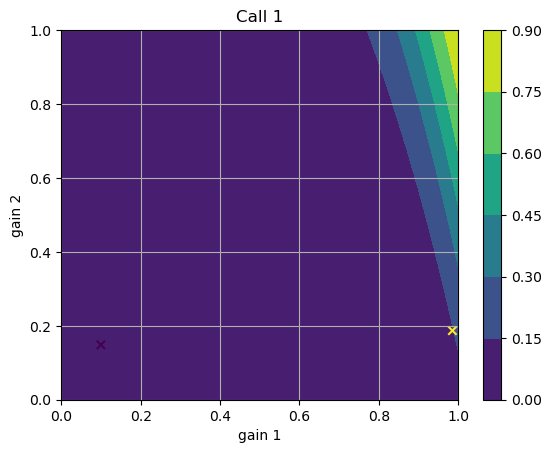

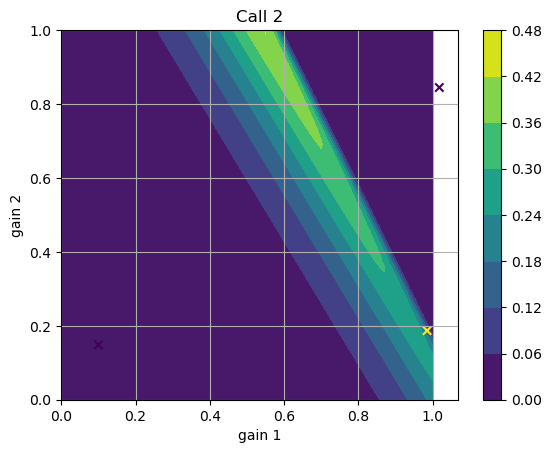

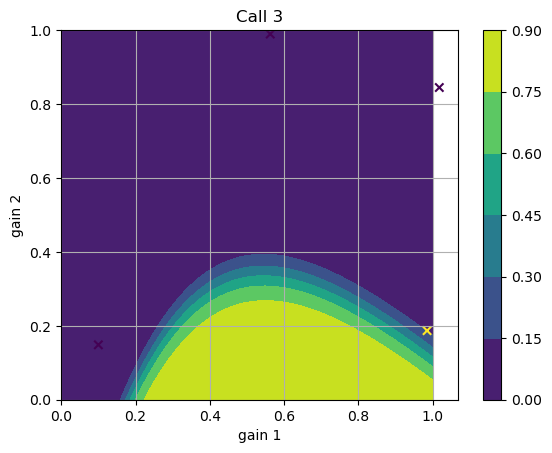

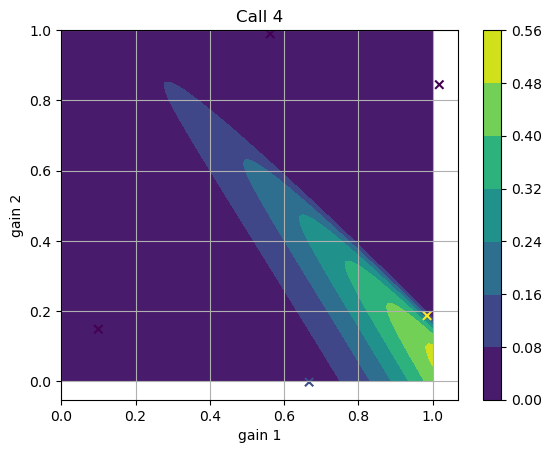

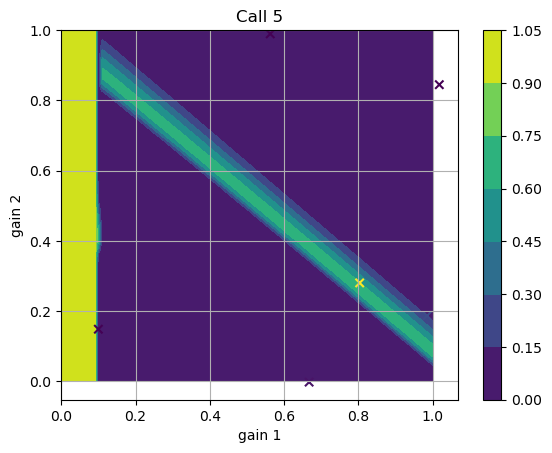

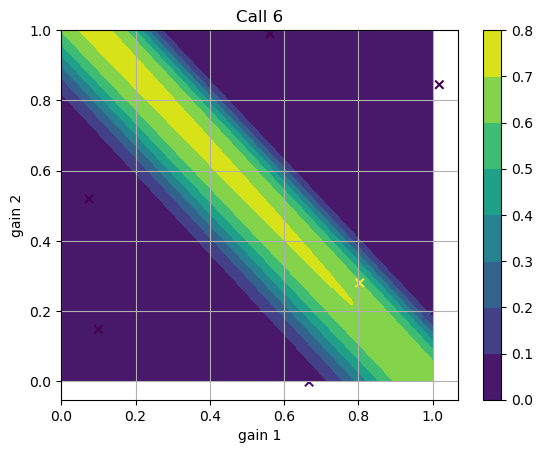

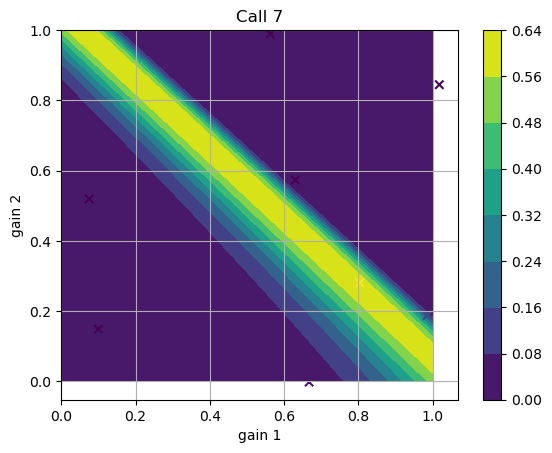

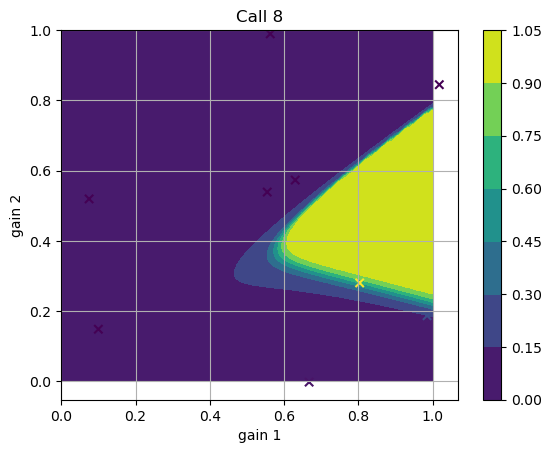

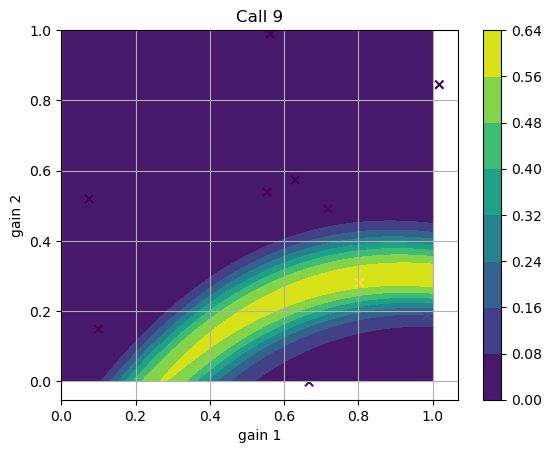

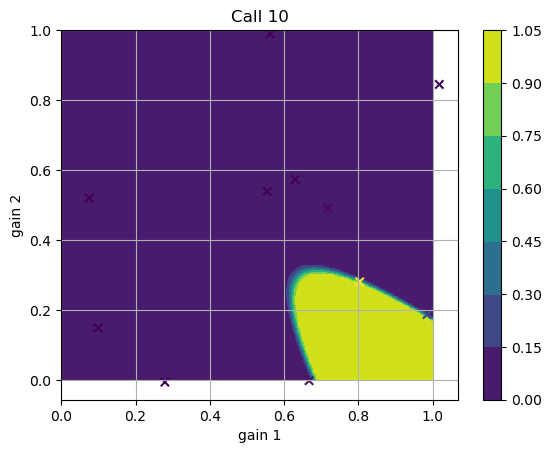

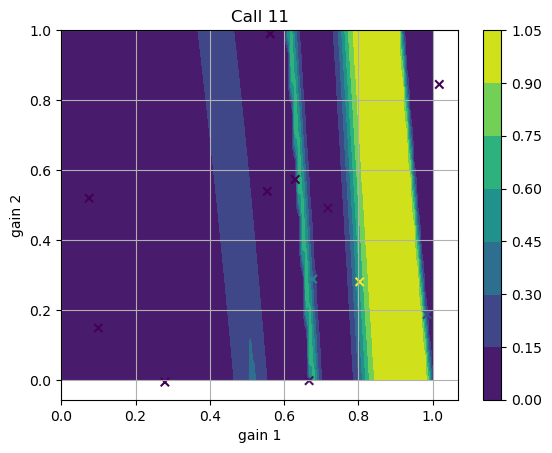

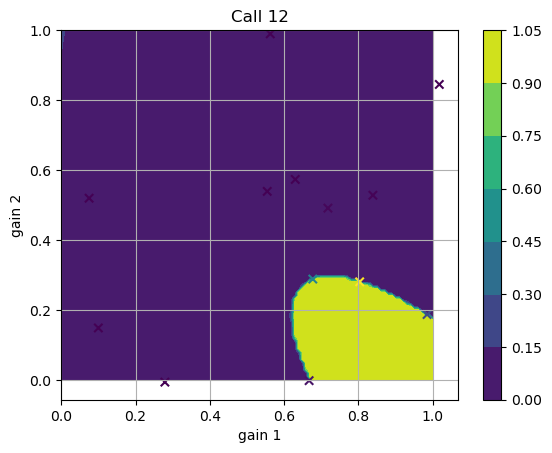

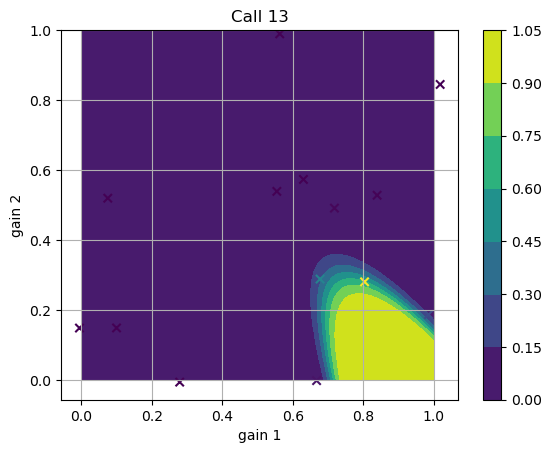

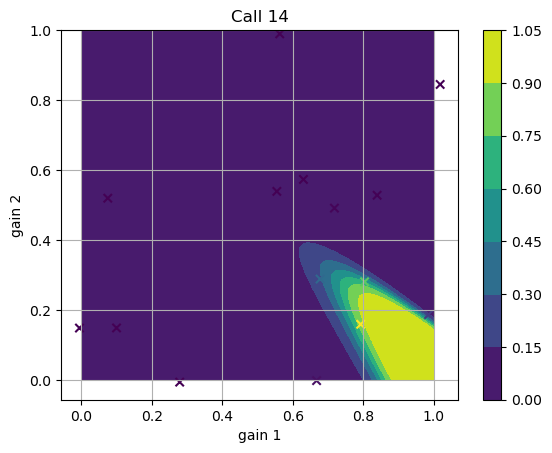

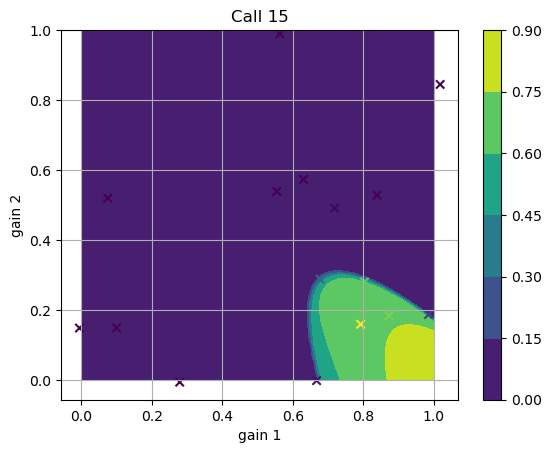

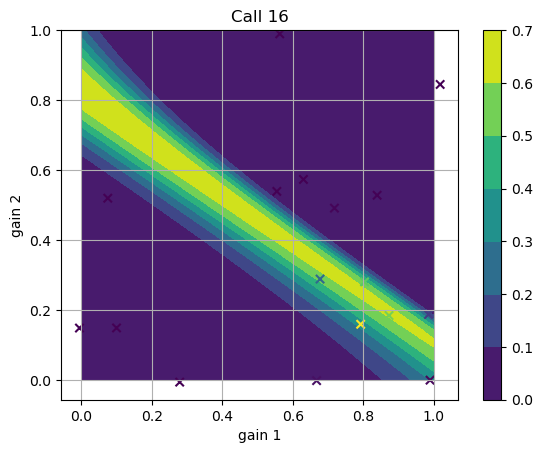

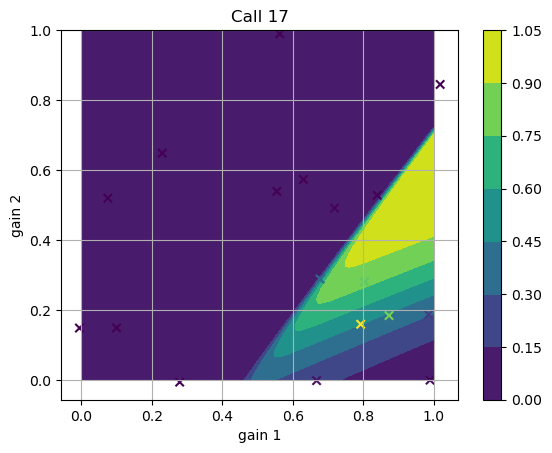

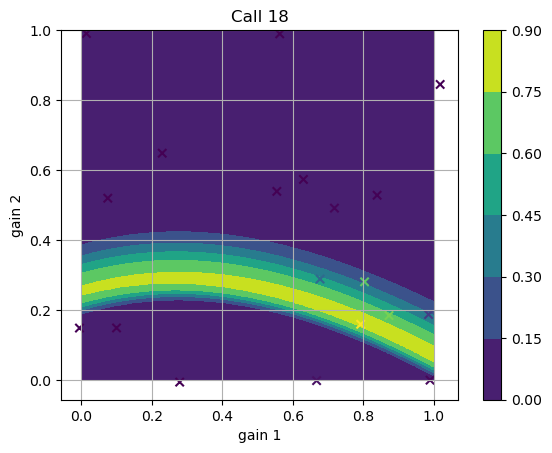

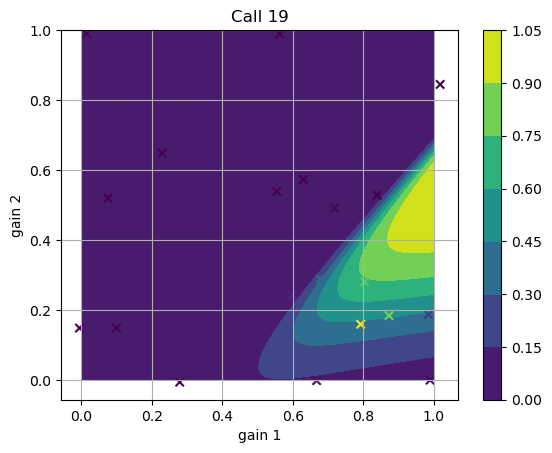

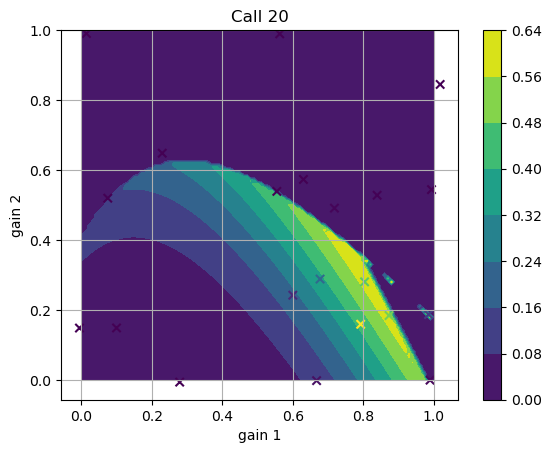


Iteration 20:
    proposal: [0.2898804605953512, 0.6202418625119753]
    response: 2.1636594373376276e-6


In [16]:
learn_user_preferences(flow_model; nr_tries=10)

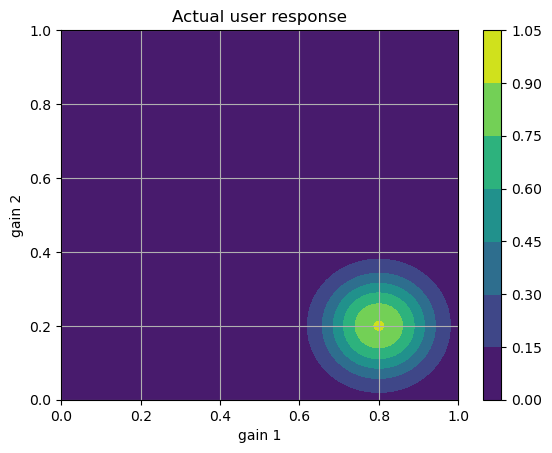

In [17]:
_, ax = plt.subplots(ncols=1)
classification_map = map((x) -> generate_user_response([x...]; μ=[0.8, 0.2], binary=false), collect(Iterators.product(0:0.01:1, 0:0.01:1)))
im = ax.contourf(repeat(0:0.01:1, 1, 101), repeat(0:0.01:1, 1, 101)', classification_map)
plt.colorbar(im, ax=ax)
ax.grid()
ax.set_xlabel("gain 1"), ax.set_ylabel("gain 2")
ax.set_title("Actual user response");